# Booking - Previsão de Cancelamentos

## Objetivo
Criar um modelo que consiga classificar as reservas do booking quanto a probabilidade de cancelamento

## Estrutura do Notebook
1. Data Preparing
    1. Tratamento da base de dados
    2. Feature Engineering
    3. Análise Exploratória
2. Modelo Preditivo
    1. Normalização, Encoding e Preparação do dataset para o modelo
    2. Treino e Teste do Modelo
        1. Modelo usando divisão aleatória entre treino e teste
        2. Modelo utilizando os anos como divisão
3. Conclusão dos resultados


In [1]:
# Bibliotecas Utilizadas 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import scikitplot as skplt
from imblearn.metrics import sensitivity_score, specificity_score

import warnings
warnings.filterwarnings("ignore")

# Configuração do Pandas
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 50)
pd.options.mode.chained_assignment = None

c:\Users\Pedro\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Preparing
Abaixo algumas funções úteis a serem usadas nessa etapa

In [2]:
def check_cols(data, columns):
    df_check = pd.DataFrame(zip(data[columns].dtypes.index,
                                data[columns].dtypes,
                                data[columns].nunique(),
                                data[columns].isna().sum(),
                                round(data[columns].isna().sum()/data.shape[0], 3)*100),
                            columns=['Variável', 'Tipo', 'Qtde_unicos', 'Qtde_NaN', '%_NaN'])

    return df_check.sort_values('Qtde_NaN').reset_index().drop('index', axis=1)

In [3]:
def properties(data, col):
    print('min: ', data[col].min(),
          'max: ', data[col].max(),
          'mean: ', data[col].mean(),
          'median: ', data[col].median(),
          'mode: ', data[col].mode())

### Tratamento dos dados

In [4]:
df = pd.read_csv('../data/raw/cancellation_prediction.csv')

df

,type,cancellation,days_between_booking_arrival,year_arrival_date,month_arrival_date,week_number_arrival_date,day_of_month_arrival_date,num_weekend_nights,num_workweek_nights,num_adults,num_children,num_babies,breakfast,country,market_segment,distribution_channel,repeated_guest,num_previous_cancellations,num_previous_stays,reserved_room,changes_between_booking_arrival,deposit_policy,id_travel_agency_booking,id_person_booking,customer_type,avg_price,required_car_parking_spaces,total_of_special_requests
0,Fancy Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,True,PRT,0,0,0,0,0,C,3,No Deposit,NaN,NaN,0,0.00,0,0
1,Fancy Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,True,PRT,0,0,0,0,0,C,4,No Deposit,NaN,NaN,0,0.00,0,0
2,Fancy Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,True,GBR,0,0,0,0,0,A,0,No Deposit,NaN,NaN,0,75.00,0,0
3,Fancy Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,True,GBR,1,1,0,0,0,A,0,No Deposit,304.0,NaN,0,75.00,0,0
4,Fancy Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,True,GBR,2,2,0,0,0,A,0,No Deposit,240.0,NaN,0,98.00,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,Hotel,0,23,2017,August,35,30,2,5,2,0.0,0,True,BEL,3,2,0,0,0,A,0,No Deposit,394.0,NaN,0,96.14,0,0
119386,Hotel,0,102,2017,August,35,31,2,5,3,0.0,0,True,FRA,2,2,0,0,0,E,0,No Deposit,9.0,NaN,0,225.43,0,2
119387,Hotel,0,34,2017,August,35,31,2,5,2,0.0,0,True,DEU,2,2,0,0,0,D,0,No Deposit,9.0,NaN,0,157.71,0,4
119388,Hotel,0,109,2017,August,35,31,2,5,2,0.0,0,True,GBR,2,2,0,0,0,A,0,No Deposit,89.0,NaN,0,104.40,0,0


In [5]:
cols_obj = [x for x in df.select_dtypes(include=['object']).columns]

cols_num = [x for x in df.select_dtypes(include=['int', 'int32', 'int64', 'float', 'float32', 'float64']).columns]

print(f'Total colunas tipo objeto: {len(cols_obj)}\nTotal de colunas tipo numerica: {len(cols_num)}')

Total colunas tipo objeto: 5
Total de colunas tipo numerica: 22


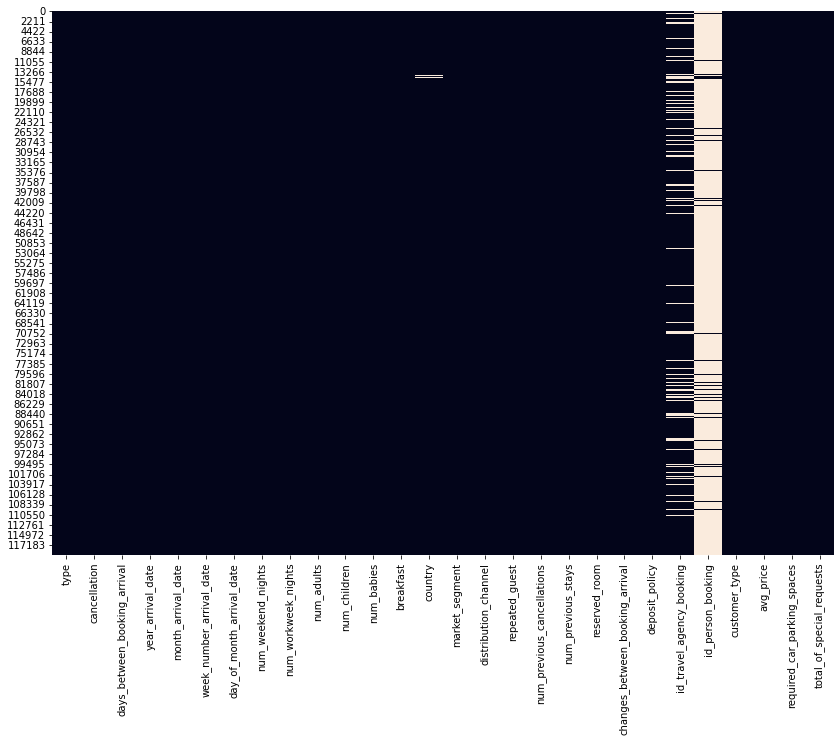

,Variável,Tipo,Qtde_unicos,Qtde_NaN,%_NaN
0,type,object,2,0,0.0
1,avg_price,float64,8726,0,0.0
2,customer_type,int64,4,0,0.0
3,deposit_policy,object,3,0,0.0
4,changes_between_booking_arrival,int64,21,0,0.0
5,reserved_room,object,10,0,0.0
6,num_previous_stays,int64,73,0,0.0
7,num_previous_cancellations,int64,15,0,0.0
8,repeated_guest,int64,2,0,0.0
9,distribution_channel,int64,5,0,0.0


In [6]:
# Identificando onde ocorrem os nulos no dataset

plt.figure(figsize=[14,10])
sns.heatmap(df.isna(), annot=False, cbar=False)
plt.show()

check_cols(df, df.columns)

*Percepções: As colunas referentes ao ID da agência de viagens e a pessoa responsável pela reserva, estão majoritariamente nulas. Levando em consideração que nosso objetivo aqui é encontrar as características que contribuem para que ocorra ou não cancelamento da reserva, remover essas colunas não trará impacto negativo ao modelo, por serem apenas identificadores. Para o caso da coluna 'country', identificamos a presença de alguns nulos, caso seja significativo (superior a 1% do dataset) esses campos serão preenchidos pelo valor mais frequente da coluna, caso contrário, a ação adotada é de apenas remover essas linhas, visto que a perda de dados não será significativa*

In [7]:
# Removendo colunas majoritariamente nulas

cols2exc = ['id_person_booking', 'id_travel_agency_booking']

df.drop(columns=cols2exc, inplace=True)

In [8]:
col2test = 'country'

nan_qtd = df[col2test].isna().sum()
df_size = df.shape[0]

pct_test = nan_qtd / df_size

if pct_test > 0.01:
    print(f"Percentual do teste: {pct_test.round(2)} \n Ação recomendada: Substituir pelo valor mais frequente")

    # Encontre o valor mais frequente na coluna
    most_frequent_value = df[col2test].mode().iloc[0, 0]  # Acessar o valor mais frequente usando .iloc

    # Substitua os valores ausentes pelo valor mais frequente
    df[col2test] = df[col2test].fillna(most_frequent_value)

    print("Substituição realizada!")

else:
    print(f"Percentual do teste: {pct_test.round(4)} \n Ação recomendada: Remover linhas com nulos")

    df = df.dropna()

    print("Remoção realizada!")


Percentual do teste: 0.0041 
 Ação recomendada: Remover linhas com nulos
Remoção realizada!


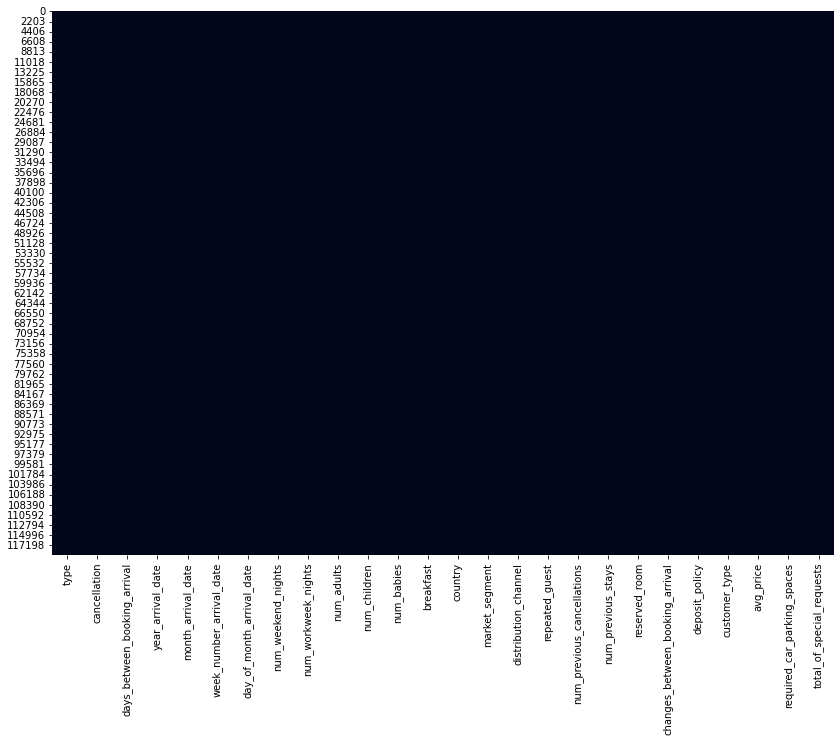

,Variável,Tipo,Qtde_unicos,Qtde_NaN,%_NaN
0,type,object,2,0,0.0
1,avg_price,float64,8717,0,0.0
2,customer_type,int64,4,0,0.0
3,deposit_policy,object,3,0,0.0
4,changes_between_booking_arrival,int64,21,0,0.0
5,reserved_room,object,10,0,0.0
6,num_previous_stays,int64,73,0,0.0
7,num_previous_cancellations,int64,15,0,0.0
8,repeated_guest,int64,2,0,0.0
9,distribution_channel,int64,5,0,0.0


In [9]:
# Identificando se os nulos foram solucionados após as tratativas

plt.figure(figsize=[14,10])
sns.heatmap(df.isna(), annot=False, cbar=False)
plt.show()

check_cols(df, df.columns)

*Algumas colunas, aparentam ter comportamento booleano, tendo que ser do tipo 'bool', entretanto estão como 'int', o próximo passo é formatar corretamente essas colunas*

In [10]:
df['repeated_guest'].value_counts()

0    115092
1      3806
Name: repeated_guest, dtype: int64

In [11]:
df['repeated_guest'] = np.where(df.repeated_guest==1,True, False)

df['repeated_guest'].value_counts()

False    115092
True       3806
Name: repeated_guest, dtype: int64

In [12]:
# Transformando colunas categóricas que estão no tipo numérico em categorias
cols2change = ['type', 'customer_type', 'distribution_channel', 'market_segment', 'year_arrival_date']

for col in cols2change:
    df[col] = df[col].astype(str)

### Feature Engineering
Foi observado que existem colunas referentes a partes da data que podem ser usadas para criar a data referente a data de entrada da reserva. Ainda identificamos a possibilidade de criar features referentes a quantidade de dias da reserva.

In [13]:
# Criando coluna de data a partir das colunas que contém as partes das datas

# Mapeando os nomes dos meses para números de mês
month_map = {
    "january": 1, "february": 2, "march": 3, "april": 4,
    "may": 5, "june": 6, "july": 7, "august": 8,
    "september": 9, "october": 10, "november": 11, "december": 12
}

# Convertendo os nomes dos meses em números usando o método map
df['month_number_arrival_date'] = df['month_arrival_date'].str.lower().map(month_map)

# Criando uma nova coluna 'date_string' com o formato 'yyyy-mm-dd'
df['date_string'] = df['year_arrival_date'].astype(str) + '-' + df['month_number_arrival_date'].astype(str).str.zfill(2) + '-' + df['day_of_month_arrival_date'].astype(str).str.zfill(2)

# Convertendo a coluna 'date_string' em uma coluna de data 'arrival_date'
df['arrival_date'] = pd.to_datetime(df['date_string'])

df.drop(columns='date_string', inplace=True)

In [14]:
# Criando coluna "total_nights"
df['total_nights'] = df['num_weekend_nights']+df['num_workweek_nights']

# Usando a coluna criada para obter "departure_date"
df['departure_date'] = df['arrival_date'] + pd.to_timedelta(df['total_nights'], unit='D')

In [15]:
# Criando coluna total_people referente a quantidade total de pessoas na reserva

df['total_people'] = df['num_babies']+df['num_children']+df['num_adults']

In [16]:
# Criando função senoidal relativa aos meses

# Parâmetros para transformar a coluna 'month_number_arrival_date' em função senoidal
amplitude = 1.0  # Amplitude da função senoidal
offset = 0.0  # Deslocamento vertical da função senoidal
periodo = 12.0  # Período da função senoidal (número de meses em um ciclo)

# Aplicar a transformação senoidal à coluna 'mes'
df['month_sine'] = amplitude * np.sin(2 * np.pi * df['month_number_arrival_date'] / periodo) + offset

*Explicação: Foi realizada a transformação de meses para função senoidal para que o modelo interprete os meses de forma similar a um relógio, dessa forma, o modelo entende, por exemplo, que o mês de janeiro (1) está mais próximo do mês de dezembro (12), do que maio (5). Essa comparação não seria possível se utilizássemos a coluna com os meses representados de forma numérica ordinal (1, 2, 3, 4, etc)*

### Análise Exploratória

In [17]:
# Testando a provável presença de valores que representam anomalias e/ou outliers

num_cols = [
    'avg_price','num_previous_stays','num_previous_cancellations',
    'total_people','total_nights', 'days_between_booking_arrival']

for var in num_cols:
    print(f'valores para a variavel: {var}')
    properties(df, var) 
    print('------------------------------------------------------------------------------------')

valores para a variavel: avg_price
min:  0.0 max:  300.0 mean:  101.8904423118976 median:  95.0 mode:  0    62.0
dtype: float64
------------------------------------------------------------------------------------
valores para a variavel: num_previous_stays
min:  0 max:  72 mean:  0.13163383740685294 median:  0.0 mode:  0    0
dtype: int64
------------------------------------------------------------------------------------
valores para a variavel: num_previous_cancellations
min:  0 max:  26 mean:  0.08714191996501203 median:  0.0 mode:  0    0
dtype: int64
------------------------------------------------------------------------------------
valores para a variavel: total_people
min:  0.0 max:  55.0 mean:  1.9705461824420931 median:  2.0 mode:  0    2.0
dtype: float64
------------------------------------------------------------------------------------
valores para a variavel: total_nights
min:  0 max:  57 mean:  3.431041733250349 median:  3.0 mode:  0    2
dtype: int64
-------------------

*Explicação: Esse teste é realizado para verificar a existência de variáveis com comportamentos anômolos, apesar de termos distâncias elevadas entre os máximos e mínimos, os valores de média e mediana estão bem próximos, o que indica que as variáveis estão coerentes.*

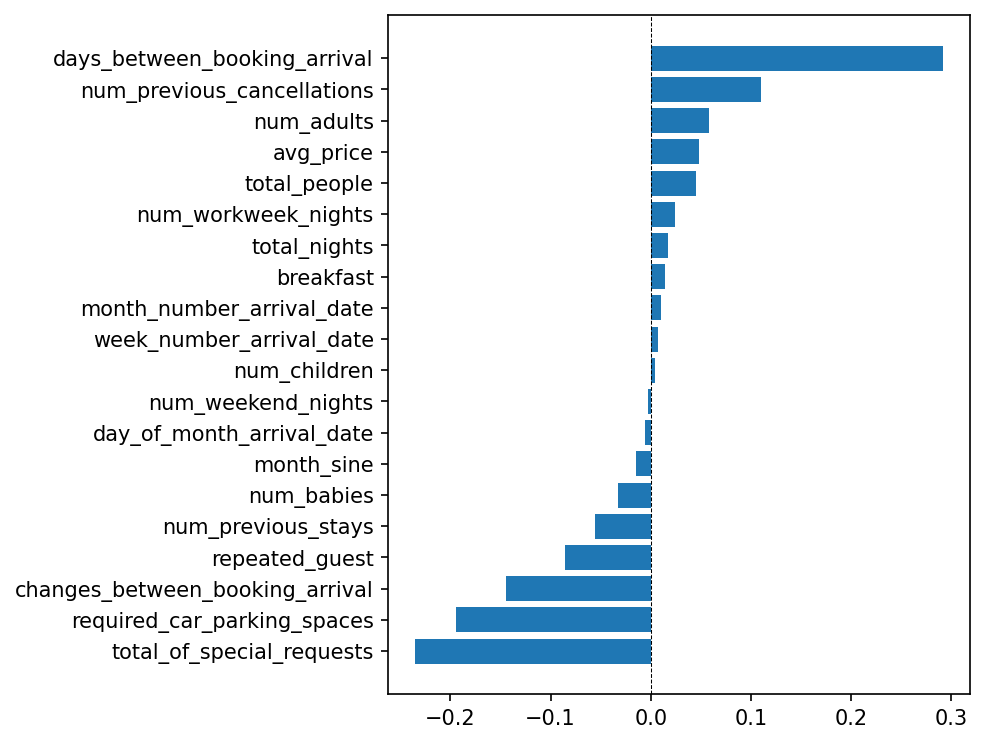

In [18]:
# Identiticando se existem variáveis autocorrelacionadas com o target "cancellation"

corr_temp = df.corr().iloc[1:,0].sort_values(ascending=False) 

fig, ax = plt.subplots(1,1,figsize=(5,6), dpi=150)
ax.barh(corr_temp.keys(),corr_temp.values, align='center')          
ax.invert_yaxis()
ax.axvline(0,c='black',lw=.5,ls='--')
plt.show()

del corr_temp

*Explicação: Verificamos que as variáveis não apresentam correlações que indicam autocorrelação (próximas de +1 ou -1), dessa forma podemos seguir com as features de todo o dataset, futuramente, serão selecionadas as mais significativas através do RFECV*

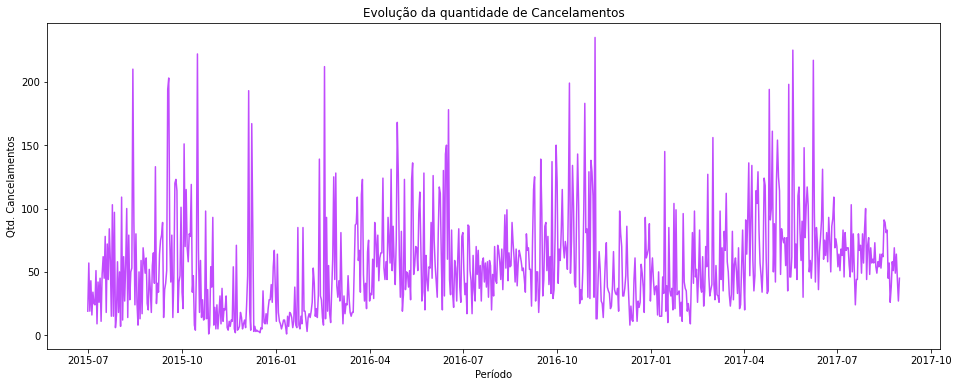

In [19]:
# Identificando evolução dos cancelamentos

df_plot = pd.DataFrame(df[df.cancellation==1].groupby(['arrival_date'])['cancellation'].count()).reset_index()

plt.figure(figsize=[16,6])
sns.lineplot(
    x='arrival_date',
    y='cancellation',
    data=df_plot,
    color='#c04cfd')
plt.xlabel('Período')
plt.ylabel('Qtd. Cancelamentos')
plt.title('Evolução da quantidade de Cancelamentos')
plt.show()

del df_plot

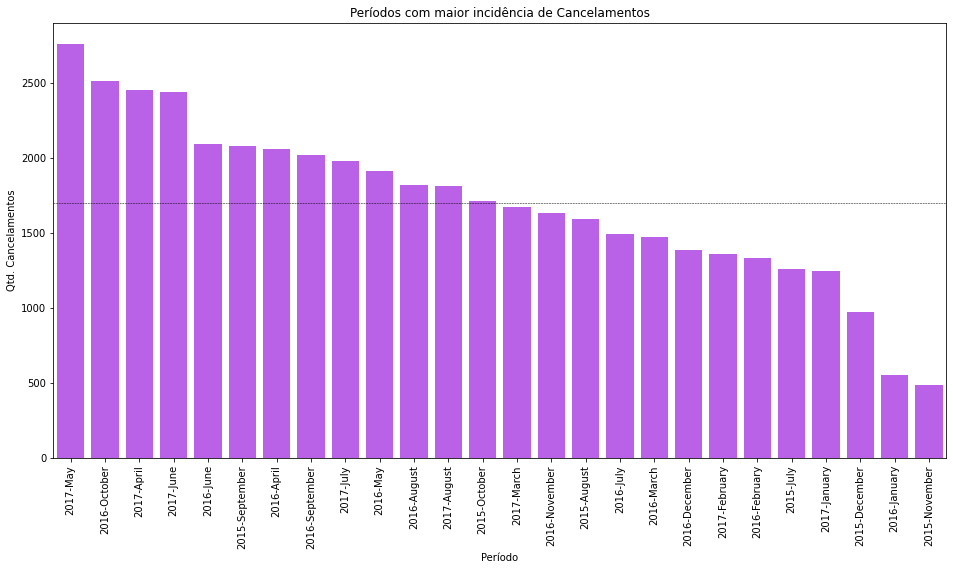

In [20]:
# Identificando meses com maior incidencia de cancelamentos

df_plot = pd.DataFrame(df[df.cancellation==1].groupby(['year_arrival_date', 'month_arrival_date'])['cancellation'].count()).reset_index()
df_plot['year_month'] = df_plot['year_arrival_date'].astype(str) + '-' + df_plot['month_arrival_date'].astype(str)
df_plot.sort_values(by='cancellation', ascending=False, inplace=True)

plt.figure(figsize=[16,8])
sns.barplot(
    x='year_month',
    y='cancellation',
    data=df_plot,
    color='#c04cfd')
plt.axhline(np.mean(df_plot.cancellation), c='black', lw=.5, ls='--', label='Média de Cancelamentos')
plt.xticks(rotation=90)
plt.xlabel('Período')
plt.ylabel('Qtd. Cancelamentos')
plt.title('Períodos com maior incidência de Cancelamentos')
plt.show()

del df_plot

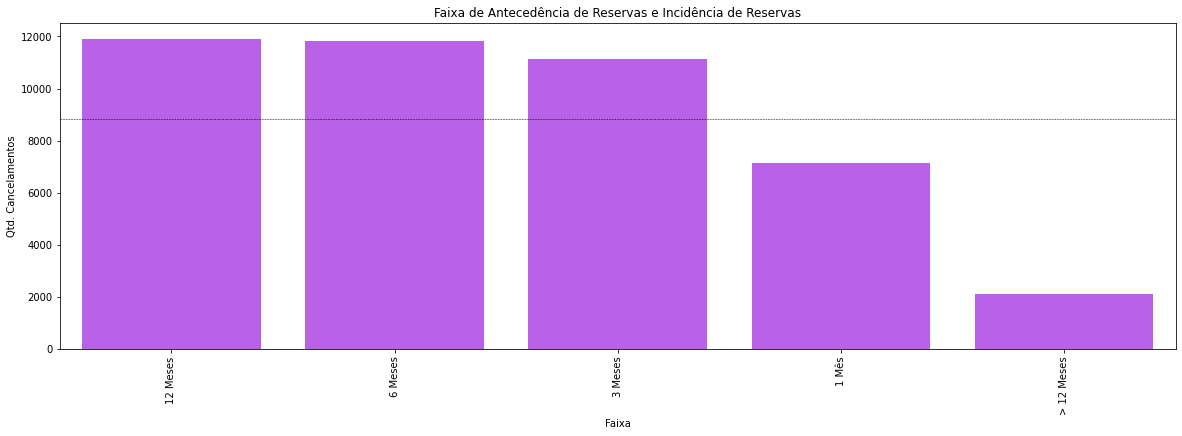

In [21]:
# Identificando faixas de meses com maior incidencia de cancelamentos

df_plot = df[df.cancellation==1]
df_plot['faixa_dias_cancelamento'] = np.select([
    df_plot['days_between_booking_arrival'].between(0,30), # Reservas feitas com um mês de antecedência
    df_plot['days_between_booking_arrival'].between(31,90), # Reservas feitas com 3 meses de antecedência
    df_plot['days_between_booking_arrival'].between(91,180), # Reservas feitas com 6 meses de antecedência
    df_plot['days_between_booking_arrival'].between(181,365), # Reservas feitas com 12 meses de antecedência
    df_plot['days_between_booking_arrival'] > 365], # Reservas feitas com mais de um ano de antecedência
    ['1 Mês', '3 Meses', '6 Meses', '12 Meses', '> 12 Meses'])
df_plot = pd.DataFrame(df_plot.groupby(['faixa_dias_cancelamento'])['cancellation'].count()).reset_index()
df_plot.sort_values(by='cancellation', ascending=False, inplace=True)


plt.figure(figsize=[20,6])
sns.barplot(
    x='faixa_dias_cancelamento',
    y='cancellation',
    data=df_plot,
    color='#c04cfd')
plt.axhline(np.mean(df_plot.cancellation), c='black', lw=.5, ls='--', label='Média de Cancelamentos')
plt.xticks(rotation=90)
plt.xlabel('Faixa')
plt.ylabel('Qtd. Cancelamentos')
plt.title('Faixa de Antecedência de Reservas e Incidência de Reservas')
plt.show()

del df_plot

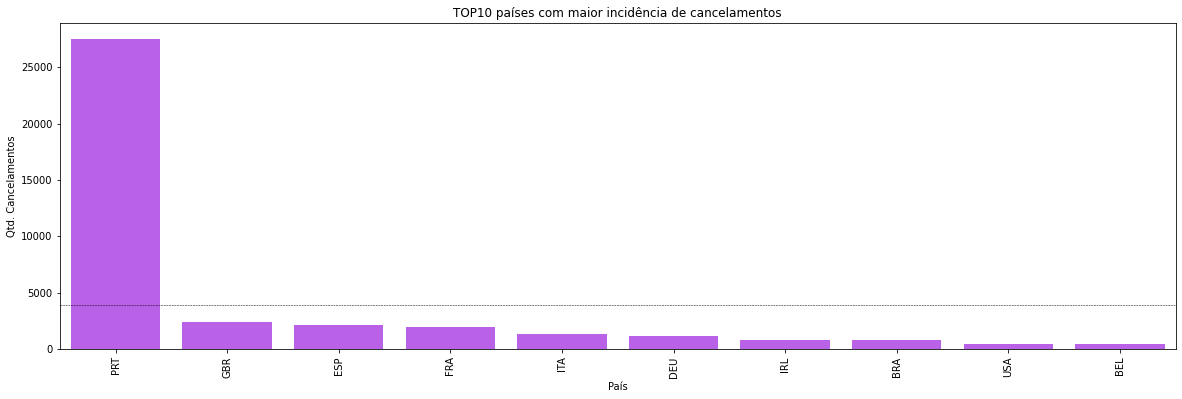

In [22]:
# Identificando meses com maior incidencia de cancelamentos

df_plot = pd.DataFrame(df[df.cancellation==1].groupby(['country'])['cancellation'].count()).reset_index()
df_plot.sort_values(by='cancellation', ascending=False, inplace=True)
df_plot = df_plot.head(10)

plt.figure(figsize=[20,6])
sns.barplot(
    x='country',
    y='cancellation',
    data=df_plot,
    color='#c04cfd')
plt.axhline(np.mean(df_plot.cancellation), c='black', lw=.5, ls='--', label='Média de Cancelamentos')
plt.xticks(rotation=90)
plt.xlabel('País')
plt.ylabel('Qtd. Cancelamentos')
plt.title('TOP10 países com maior incidência de cancelamentos')
plt.show()

del df_plot

*Percepções: Com os gráficos analisando a questão da incidência de cancelamentos, observamos que nos últimos anos da base de dados a incidência de cancelamento é maior nos meses entre Abril e Setembro, indicando relação com as férias do meio do ano, verificando os países onde mais ocorrem cancelamentos, observou-se que a maioria dos cancelamentos ocorrem em reservas realizadas em Portugal (PRT). Analisando o gráfico com as faixas referentes a antecedência da reserva, é notável que a maior parte dos cancelamentos ocorrem com reservas feitas com um período de 3 meses a 1 ano de antecedência, as reservas feitas com mais de um ano de antecedência são as que apresentaram menor incidência de cancelamentos.*

## Modelo Preditivo
Antes do treino do modelo será realizada análise de RFE para encontrar as features mais significativas para o modelo, algumas colunas serão removidas pois estão cobertas por outras criadas na etapa de Feature Engineering (ex.: Coluna com o mês que foi transformada em função senoidal). Serão executados dois modelos similares que se diferem quanto a técnica usada para separar as bases de treino e teste, o primeiro será separado de forma aleatória e o segundo usando para treino os anos de 2015 e 2016, com o teste no ano de 2017.

Abaixo algumas funções úteis a serem usadas nessa etapa

In [23]:
def get_cols(df, target='cancellation', cols2exc=[]):
    '''
    Separa as features para normalização, enconding e target
    '''
    # features que passarão pelo enconding - objetos 
    cols2enc = [target] + [x for x in df.select_dtypes(include=['object']).columns if x not in cols2exc and x not in [target]]
    # features que serão normalizadas
    cols2norm = [x for x in df.select_dtypes(include=['int64', 'float64']).columns if x not in cols2exc and x not in cols2enc] 
        
    return cols2enc, cols2norm 

def normalizing(df, target='cancellation', cols2exc=[]):
    '''
    Aplica o enconding e normalização aos dados
    '''   
    # separate cols
    cols2enc, cols2norm = get_cols(df, target, cols2exc)
    #print(cols2enc, cols2norm)
    df_norm = pd.DataFrame()
    
    # encoding 
    enc_mapping = list()
    encoder = LabelEncoder()
    for col in cols2enc:
        encoded = encoder.fit_transform(df[col])#.astype(str))
        df_norm[col] = encoded
        mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
        enc_mapping.append([col, mapping])
        
    # normalizing
    scaler = MinMaxScaler()
    for col in cols2norm:
        encoded = scaler.fit_transform(df[col].astype(float).values.reshape(-1, 1))
        df_norm[col] = encoded
        
    return df_norm, enc_mapping

In [24]:
def get_model(X, y, nsplit=3, min_features=10, njobs=-1):
    '''
    Retorna o RFE + CV 
    '''
    rfc = RandomForestClassifier(random_state=13, class_weight='balanced')
    kfold = StratifiedKFold(n_splits=nsplit, shuffle=True) 
    cv = kfold.split(X, y)
    return RFECV(estimator=rfc, step=nsplit, min_features_to_select=min_features, cv=cv, n_jobs=njobs)

In [25]:
def get_features_info(rfecv, X, df, style=None):
    '''
    Retorna a análise das features selecionadas pelo RFECV + dataframe com essas features
    '''
    print('Número ótimo de variáveis selecionadas pelo RFE: {}'.format(rfecv.n_features_))
    
    if not style:
        style = {'font-family': 'manrope', 
                 'color-header': 'white',
                 'background-header': '#000000',
                 'header-fsize': '16px',
                 'background-even': '#7a7423',
                 'background-odd': '#a7e82b',
                 'rows-fsize' : '14px',
                 'figsize': (12,12),
                 'cmap': 'Greens',
                 'color': '#c04cfd'}
        
    # Visualizando as importancia das variáveis selecionadas
    X2 = X.drop(X.columns[np.where(rfecv.support_ == False)[0]], axis=1)
    dset = pd.DataFrame()
    dset['attr'] = X2.columns
    dset['importance'] = rfecv.estimator_.feature_importances_
    dset = dset.sort_values(by='importance', ascending=True)

    fig, axs = plt.subplots(2,1, figsize=style['figsize'], gridspec_kw={'height_ratios': [1, 3]})
    fig.suptitle('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold')
    axs[0].plot(range(1, len(rfecv.cv_results_["mean_test_score"]) + 1), rfecv.cv_results_["mean_test_score"], 
                color=style['color'], linewidth=3)
    axs[0].set_xlabel('Number of features selected', fontsize=14, labelpad=20)
    axs[0].set_ylabel('% Correct Classification', fontsize=14, labelpad=20)
    axs[1].barh(y=dset['attr'], width=dset['importance'], color=style['color'])
    axs[1].set_xlabel('Importancia', fontsize=14, labelpad=20)
    
    # Tabela com as variáveis e seu percentual de importancia
    df_import = pd.DataFrame(zip(dset.attr, [f'{x*100:.2f}%' for x in dset.importance.sort_values(ascending=True)]), columns=['Variável', 'Importancia'])
    print(df_import)

    # Variáveis selecionadas pelo RFE/RF
    cols_rfe = dset.attr
    # Dataframe com as features selecionadas 
    return df_import, df[cols_rfe.tolist()]

In [26]:
def work_model(model=None, ftype='pkl', path2save='../../models/', outname='model'):

    '''
    Salva ou carrega um modelo

    inputs:
    model = modelo a ser salvo
    ftype = tipo do arquivo, pkl ou joblib
    path2save = path para salvar/carregar o modelo: ex.: '../../models'
    outname = nome para o output - nome do modelo 

    output:
    retorna = arquivo salvo ou modelo carregado

    '''

    import os
    import joblib
    import pickle

    outname = os.path.join(path2save, outname)
    outfile = f"{outname}.{ftype}"

    if ftype == 'pkl':
        if model: # save
            pickle.dump(model, open(outfile, 'wb'))
            print(f'Model saved as {outfile}')  

        else: # load
            return pickle.load(open(f'{outfile}', 'rb'))

    else:
        if model:
            joblib.dump(model, outfile)
            print(f'Model saved as {outfile}')  

        else:
            return joblib.load(f'{outfile}')

In [27]:
def fit_model(X, y, model=RandomForestClassifier()):

    '''
    Fit modelos aos dados

    '''

    model.fit(X, y)

    return model

### Normalização, Encoding e Preparação do dataset para o modelo

In [28]:
cols_exc = ['month_arrival_date','day_of_month_arrival_date', 'month_number_arrival_date']

df_norm, enc_mapping = normalizing(df, target='cancellation', cols2exc=cols_exc)

df_norm.to_csv('../data/intermediate/df_normalized.csv', sep=';', index=False)

In [29]:
df_norm.head(5)

,cancellation,type,year_arrival_date,country,market_segment,distribution_channel,reserved_room,deposit_policy,customer_type,days_between_booking_arrival,week_number_arrival_date,num_weekend_nights,num_workweek_nights,num_adults,num_children,num_babies,num_previous_cancellations,num_previous_stays,changes_between_booking_arrival,avg_price,required_car_parking_spaces,total_of_special_requests,total_nights,total_people,month_sine
0,0,0,0,135,0,0,2,0,0,0.464043,0.5,0.0,0.00000,0.036364,0.0,0.0,0.0,0.0,0.142857,0.000000,0.0,0.0,0.000000,0.036364,0.25
1,0,0,0,135,0,0,2,0,0,1.000000,0.5,0.0,0.00000,0.036364,0.0,0.0,0.0,0.0,0.190476,0.000000,0.0,0.0,0.000000,0.036364,0.25
2,0,0,0,59,0,0,0,0,0,0.009498,0.5,0.0,0.02439,0.018182,0.0,0.0,0.0,0.0,0.000000,0.250000,0.0,0.0,0.017544,0.018182,0.25
3,0,0,0,59,1,1,0,0,0,0.017639,0.5,0.0,0.02439,0.018182,0.0,0.0,0.0,0.0,0.000000,0.250000,0.0,0.0,0.017544,0.018182,0.25
4,0,0,0,59,2,2,0,0,0,0.018996,0.5,0.0,0.04878,0.036364,0.0,0.0,0.0,0.0,0.000000,0.326667,0.0,0.2,0.035088,0.036364,0.25


In [30]:
# Inserindo variáveis NOISE e separando features do target

cols2exc=[]
target = ['cancellation']

# Insere noise
df_norm['NOISE1'] = np.random.normal(0, 1, df_norm.shape[0])
df_norm['NOISE2'] = np.random.rand(df_norm.shape[0])

X = df_norm.drop(cols2exc+target, axis=1) # Features
y = df_norm[target[0]].values # Target

In [31]:
# Estancia o modelo

rfecv = get_model(X, y, nsplit=3, min_features = 5)

In [32]:
# Fit do modelo

%time rfecv.fit(X,y)

Wall time: 4min 15s


RFECV(cv=<generator object _BaseKFold.split at 0x0000028E80732BA0>,
      estimator=RandomForestClassifier(class_weight='balanced',
                                       random_state=13),
      min_features_to_select=5, n_jobs=-1, step=3)

Número ótimo de variáveis selecionadas pelo RFE: 26
                           Variável Importancia
0                        num_babies       0.07%
1                      num_children       0.45%
2                num_previous_stays       0.50%
3                        num_adults       0.86%
4                              type       1.03%
5                      total_people       1.12%
6                     reserved_room       1.44%
7                num_weekend_nights       1.63%
8              distribution_channel       1.64%
9                        month_sine       2.32%
10  changes_between_booking_arrival       2.33%
11       num_previous_cancellations       2.36%
12              num_workweek_nights       2.41%
13                year_arrival_date       2.76%
14                    customer_type       2.94%
15                     total_nights       3.03%
16      required_car_parking_spaces       3.13%
17         week_number_arrival_date       5.36%
18        total_of_special_requests 

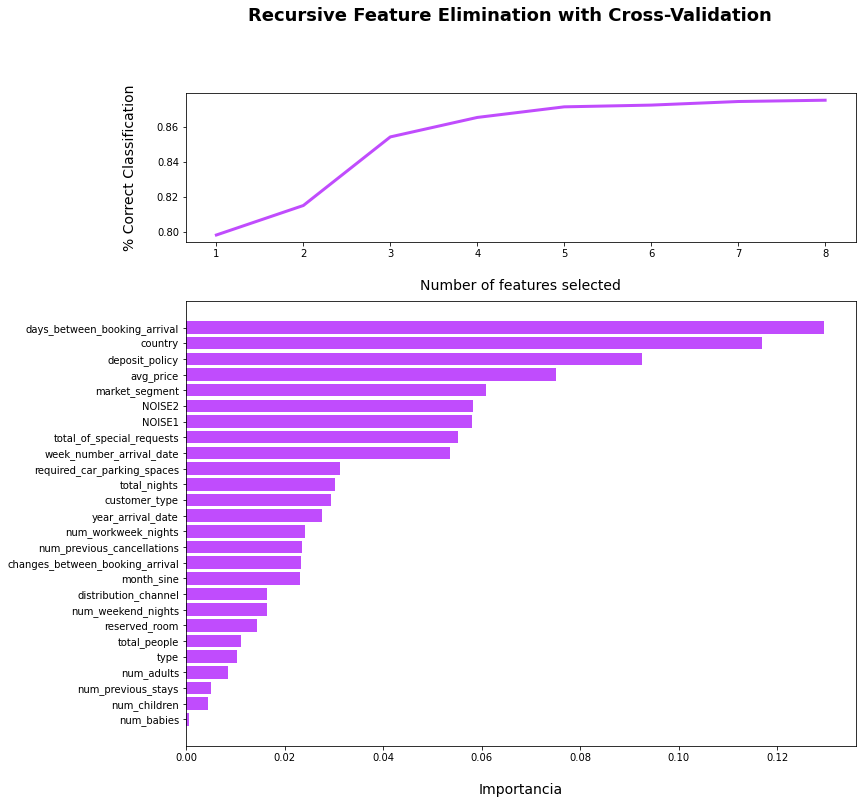

In [33]:
df_imp, df_rfe = get_features_info(rfecv, X, df_norm)

*Explicação: A técnica do Recursive Feature Elimination (RFE) demonstra quais são as features que apresentam maior importância para o resultado da predição. Para esse caso, selecionamos as features que estão acima do NOISE2, sendo elas 'days_between_booking_arrival', 'country', 'deposit_policy', 'avg_price' e 'market_segment'. Fazemos essas seleções, pois as demais features demonstraram possuir uma importância menor do que a de uma variável 100% aleatória (variáveis NOISE), dessa forma, o uso dessas features ou não no modelo, não traz mudanças significativas. Obs.: As colunas com o ano referente a data de início da reserva e o target, foram mantidas para permitir a separação do DataSet utilizando os anos como critério.*

In [34]:
df_rfe[target[0]] = y # Target
df_rfe = df_rfe[['days_between_booking_arrival', 'country', 'deposit_policy', 'avg_price', 'market_segment','year_arrival_date','cancellation']].copy() 
df_rfe.to_csv('../data/intermediate/rfe_data.csv', sep=';')

In [35]:
df_rfe

,days_between_booking_arrival,country,deposit_policy,avg_price,market_segment,year_arrival_date,cancellation
0,0.464043,135,0,0.000000,0,0,0
1,1.000000,135,0,0.000000,0,0,0
2,0.009498,59,0,0.250000,0,0,0
3,0.017639,59,0,0.250000,1,0,0
4,0.018996,59,0,0.326667,2,0,0
...,...,...,...,...,...,...,...
118893,0.031208,15,0,0.320467,3,2,0
118894,0.138399,56,0,0.751433,2,2,0
118895,0.046133,43,0,0.525700,2,2,0
118896,0.147897,59,0,0.348000,2,2,0


### Treino do Modelo e teste do modelo
#### Modelo usando divisão aleatória entre treino e teste

<AxesSubplot:title={'center':'Test Sample'}, ylabel='count'>

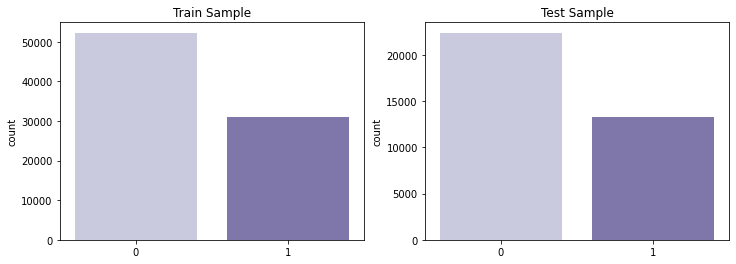

In [36]:
X = df_rfe.drop(columns=['year_arrival_date','cancellation'])

# Divisão dos dados (train_test_split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30, stratify=y)

# Check da distribuição do target
fig, axs = plt.subplots(1,2, figsize=[12,4])
axs[0].title.set_text('Train Sample')
sns.countplot(x=y_train, ax=axs[0], palette='Purples')
axs[1].title.set_text('Test Sample')
sns.countplot(x=y_test, ax=axs[1], palette='Purples')

*Percepções: Verificando a distribuição das classes separadas entre treino e test, vimos que o dataset segue uma proporção, sendo possível seguir com a modelagem nesse formato*

In [37]:
# Função de objetivo para otimização com Optuna
def objective(trial):
    # Definição do espaço de busca para os hiperparâmetros
    param_dist = {
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'max_depth': trial.suggest_int('max_depth', 5, 50),
        'min_samples_split': trial.suggest_int('min_samples_split', 5, 50),
        'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced', 'balanced_subsample']),
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss'])
    }

    # Instância do classificador com os hiperparâmetros sugeridos
    clf = RandomForestClassifier(random_state=13, n_jobs=-1, **param_dist)

    # Avaliação do desempenho do modelo usando validação cruzada
    score = cross_val_score(clf, X_train, y_train, cv=3, n_jobs=-1).mean()

    return -score  # Objetivo é minimizar o erro, por isso usamos o negativo do score

# Criando um estudo Optuna
study = optuna.create_study(direction='maximize')  # 'maximize' para maximizar o score

# Otimização de hiperparâmetros
study.optimize(objective, n_trials=50)  # Ajuste o número de trials conforme necessário

# Melhores hiperparâmetros
best_params = study.best_params

print("Melhores hiperparâmetros:", best_params)

[I 2023-09-16 12:02:50,040] A new study created in memory with name: no-name-4de9386c-7961-4f15-af39-c2cce2baa190
[I 2023-09-16 12:02:53,899] Trial 0 finished with value: -0.7563199335358077 and parameters: {'max_features': 'log2', 'max_depth': 6, 'min_samples_split': 18, 'class_weight': 'balanced', 'criterion': 'gini'}. Best is trial 0 with value: -0.7563199335358077.
[I 2023-09-16 12:02:58,111] Trial 1 finished with value: -0.792726005755688 and parameters: {'max_features': 'log2', 'max_depth': 10, 'min_samples_split': 30, 'class_weight': None, 'criterion': 'log_loss'}. Best is trial 0 with value: -0.7563199335358077.
[I 2023-09-16 12:03:03,723] Trial 2 finished with value: -0.8131277723995641 and parameters: {'max_features': 'log2', 'max_depth': 48, 'min_samples_split': 36, 'class_weight': None, 'criterion': 'log_loss'}. Best is trial 0 with value: -0.7563199335358077.
[I 2023-09-16 12:03:10,149] Trial 3 finished with value: -0.8099557846337103 and parameters: {'max_features': 'sqrt

Melhores hiperparâmetros: {'max_features': 'sqrt', 'max_depth': 7, 'min_samples_split': 45, 'class_weight': 'balanced_subsample', 'criterion': 'entropy'}


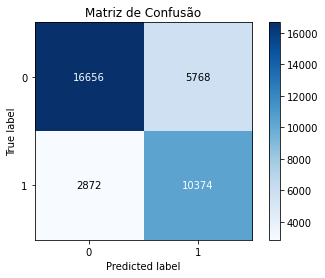

Report: 
               precision    recall  f1-score   support

      booked       0.85      0.74      0.79     22424
cancellation       0.64      0.78      0.71     13246

    accuracy                           0.76     35670
   macro avg       0.75      0.76      0.75     35670
weighted avg       0.77      0.76      0.76     35670

Accuracy: 0.758
Precision: 0.643
Recall: 0.783
F1 score: 0.706


In [44]:
# Avaliação do modelo Random Forest com os parametros otimizados com o Optuna
rfc_params = study.best_params
rfc_params['n_jobs'] = -1
rfc_params['random_state'] = 13 

rfc = fit_model(X_train, y_train, model=RandomForestClassifier(**rfc_params))

y_pred = rfc.predict(X_test)

# Plota a matriz de confusão
skplt.metrics.plot_confusion_matrix(y_test, y_pred, labels=[0, 1], title='Matriz de Confusão')
plt.show()

print('Report: \n', classification_report(y_test, y_pred, labels=[0,1], target_names=['booked','cancellation']))
print('Accuracy: %.3f' % (accuracy_score(y_test, y_pred)))
print('Precision: %.3f' % (precision_score(y_test, y_pred)))
print('Recall: %.3f' % (recall_score(y_test, y_pred)))
print('F1 score: %.3f' % (f1_score(y_test, y_pred)))

Percepções:
1. O modelo possui um recall razoavelmente alto para previsões de cancelamentos, capturando cerca de 78,3% dos casos reais de cancelamento.
2. A precisão das previsões de cancelamento é de aproximadamente 64,3%, o que indica que cerca de 64,3% das previsões de cancelamento estão corretas.
3. O F1-score, que combina precisão e recall, é de 70,6%, sugerindo um equilíbrio razoável entre as métricas de precisão e recall.
4. A acurácia geral do modelo é de aproximadamente 75,8%, o que significa que cerca de 75,8% das previsões são corretas no geral.
5. É importante considerar o contexto do problema e os custos associados aos falsos positivos e falsos negativos ao interpretar esses resultados.

In [45]:
# Salva o melhor modelo:

work_model(rfc, ftype='pkl', path2save='../models/', outname='rfc_v0')

Model saved as ../models/rfc_v0.pkl


#### Modelo utilizando os anos como divisão
Premissas:
1. Base de treino -> Anos de 2015 e 2016
2. Base de teste -> Ano de 2017
3. As divisões usam o sufixo yo (year order) para diferenciação

<AxesSubplot:title={'center':'Test Sample'}, xlabel='cancellation', ylabel='count'>

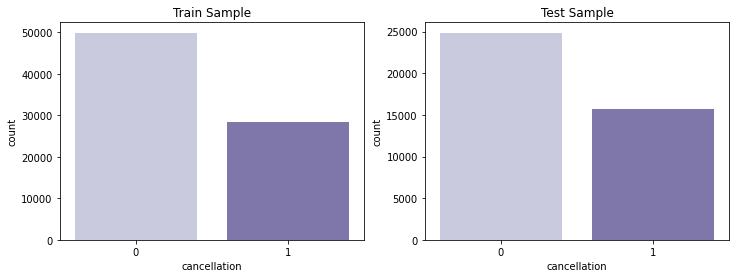

In [46]:
# Os valores referentes aos anos colocados nos filtros foram obtidos no encoding map (enc_mapping)
# mapping para o ano -> ['year_arrival_date', {'2015': 0, '2016': 1, '2017': 2}]
X_train_yo = df_rfe[df_rfe.year_arrival_date.isin([0,1])].drop(columns=['year_arrival_date','cancellation'])
X_test_yo = df_rfe[df_rfe.year_arrival_date==2].drop(columns=['year_arrival_date','cancellation'])

y_train_yo = df_rfe[df_rfe.year_arrival_date.isin([0,1])].cancellation
y_test_yo = df_rfe[df_rfe.year_arrival_date==2].cancellation

# Check da distribuição do target
fig, axs = plt.subplots(1,2, figsize=[12,4])
axs[0].title.set_text('Train Sample')
sns.countplot(x=y_train_yo, ax=axs[0], palette='Purples')
axs[1].title.set_text('Test Sample')
sns.countplot(x=y_test_yo, ax=axs[1], palette='Purples')

In [47]:
# Função de objetivo para otimização com Optuna
def objective(trial):
    # Definição do espaço de busca para os hiperparâmetros
    param_dist = {
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'max_depth': trial.suggest_int('max_depth', 5, 50),
        'min_samples_split': trial.suggest_int('min_samples_split', 5, 50),
        'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced', 'balanced_subsample']),
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss'])
    }

    # Instância do classificador com os hiperparâmetros sugeridos
    clf = RandomForestClassifier(random_state=13, n_jobs=-1, **param_dist)

    # Avaliação do desempenho do modelo usando validação cruzada
    score = cross_val_score(clf, X_train_yo, y_train_yo, cv=3, n_jobs=-1).mean()

    return -score  # Objetivo é minimizar o erro, por isso usamos o negativo do score

# Criando um estudo Optuna
study_yo = optuna.create_study(direction='maximize')  # 'maximize' para maximizar o score

# Otimização de hiperparâmetros
study_yo.optimize(objective, n_trials=50)  # Ajuste o número de trials conforme necessário

# Melhores hiperparâmetros
best_params = study_yo.best_params

print("Melhores hiperparâmetros:", best_params)

[I 2023-09-16 12:16:16,271] A new study created in memory with name: no-name-bbbfbcbe-80c9-4fb9-a877-b12104467519
[I 2023-09-16 12:16:25,315] Trial 0 finished with value: -0.6940378573070732 and parameters: {'max_features': 'log2', 'max_depth': 40, 'min_samples_split': 46, 'class_weight': 'balanced_subsample', 'criterion': 'entropy'}. Best is trial 0 with value: -0.6940378573070732.
[I 2023-09-16 12:16:30,709] Trial 1 finished with value: -0.7081130099369045 and parameters: {'max_features': 'sqrt', 'max_depth': 20, 'min_samples_split': 30, 'class_weight': None, 'criterion': 'gini'}. Best is trial 0 with value: -0.6940378573070732.
[I 2023-09-16 12:16:37,683] Trial 2 finished with value: -0.6920964569443381 and parameters: {'max_features': 'sqrt', 'max_depth': 44, 'min_samples_split': 23, 'class_weight': 'balanced_subsample', 'criterion': 'entropy'}. Best is trial 2 with value: -0.6920964569443381.
[I 2023-09-16 12:16:43,961] Trial 3 finished with value: -0.6923263596188725 and paramete

Melhores hiperparâmetros: {'max_features': 'log2', 'max_depth': 19, 'min_samples_split': 10, 'class_weight': 'balanced_subsample', 'criterion': 'entropy'}


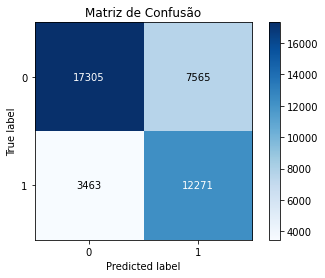

Report: 
               precision    recall  f1-score   support

      booked       0.83      0.70      0.76     24870
cancellation       0.62      0.78      0.69     15734

    accuracy                           0.73     40604
   macro avg       0.73      0.74      0.72     40604
weighted avg       0.75      0.73      0.73     40604

Accuracy: 0.728
Precision: 0.619
Recall: 0.780
F1 score: 0.690


In [48]:
# Avaliação do modelo Random Forest com os parametros otimizados com o Optuna
rfc_yo_params = study_yo.best_params
rfc_yo_params['n_jobs'] = -1
rfc_yo_params['random_state'] = 13 

rfc_yo = fit_model(X_train_yo, y_train_yo, model=RandomForestClassifier(**rfc_yo_params))

y_pred_yo = rfc.predict(X_test_yo)

# Plota a matriz de confusão
skplt.metrics.plot_confusion_matrix(y_test_yo, y_pred_yo, labels=[0, 1], title='Matriz de Confusão')
plt.show()

print('Report: \n', classification_report(y_test_yo, y_pred_yo, labels=[0,1], target_names=['booked','cancellation']))
print('Accuracy: %.3f' % (accuracy_score(y_test_yo, y_pred_yo)))
print('Precision: %.3f' % (precision_score(y_test_yo, y_pred_yo)))
print('Recall: %.3f' % (recall_score(y_test_yo, y_pred_yo)))
print('F1 score: %.3f' % (f1_score(y_test_yo, y_pred_yo)))


Percepções:
1. O modelo apresenta um recall razoavelmente alto para previsões de cancelamentos, capturando cerca de 78,0% dos casos reais de cancelamento.
2. A precisão das previsões de cancelamento é de aproximadamente 61,9%, o que indica que cerca de 61,9% das previsões de cancelamento estão corretas.
3. O F1-score, que combina precisão e recall, é de 69,0%, sugerindo um equilíbrio razoável entre as métricas de precisão e recall.
4. A acurácia geral do modelo é de aproximadamente 72,8%, o que significa que cerca de 72,8% das previsões são corretas no geral.
5. Assim como no modelo anterior, é importante considerar o contexto do problema e os custos associados aos falsos positivos e falsos negativos ao interpretar esses resultados.

In [49]:
# Salva o melhor modelo:

work_model(rfc_yo, ftype='pkl', path2save='../models/', outname='rfc_yo_v0')

Model saved as ../models/rfc_yo_v0.pkl


## Conclusões do resultado
**Questão 1 - Elabore hipóteses e visualizações envolvendo a variável cancellation e, pelo menos, outras
duas variáveis presentes no dataset**

Os gráficos criados foram elaborados na etapa de análise exploratória foram criados utilizando as linhas do dataset onde ocorreram cancelamentos, a partir deles, foram obtidos os seguintes insights:
1. As demais variáveis quando submetidas a análise de correlação, comparando com o target "cancellation", apresentaram resultados que variam de aproximadamente -0,2 a +0,3, isso indica a presença de correlações fracas entre o target e essas variáveis. A correlação por si só não é suficiente para obter conclusões a respeito do comportamento do target em relação a outras variáveis, essa análise apenas demonstra que não possuimos variáveis autocorrelacionadas reduzindo o risco de overfitting;
2. O plot da série temporal dos cancelamentos em relação a data de início das reservas demonstrou que existem períodos de maior ocorrência de cancelamento, entretanto, com a evolução do tempo a quantidade de cancelamentos permaneceu estável não demonstrando tendências de crescimento apenas avaliando esse gráfico. Para concluir se existe ou não tendência de crescimento é necessário efetuar mais análises em cima dessa série temporal, um caminho a ser seguido seria o uso do modelo Prophet para verificar a ocorrência de tendência e sazonalidade nessa série temporal;
3. Foi possível observar que ocorre grande incidência de cancelamento entre os meses de Abril e Setembro, principalmente nos anos de 2016 e 2017. Esse comportamento pode indicar uma relação entre os cancelamentos e as férias localizadas no meio do ano. Por não termos informações relativas a origem das reservas, por exemplo, se são clientes do hemisfério norte ou sul, não é possível relacionar se isso ocorre por serem férias mais curtas no caso de clientes do hemisfério sul, ou outros motivos;
4. Ao criar uma classe categorizando os dias entre a reserva e a hospedagem no caso das ocorrências de cancelamento, verificamos que a maior parte desses cancelamentos ocorrem em reservas realizadas no intervalo de 3 a 12 meses de antecedência, reservas feitas com mais de um ano de antecedência ou com menos de um mês apresentaram poucas ocorrências de cancelamento;
5. Ao comparar a incidência de cancelamentos nos diferentes países onde ocorrem as reservas, foi possível observar que a base esta fortemente concentrada em cancelamentos ocorridos em Portugal (PRT), os demais países presentes na base indicaram cancelamentos inferiores a aproximadamente 10% da quantidade observada em Portugal, não foram encontradas informações ou notícias que justificassem esse excesso de cancelamentos durante os períodos presentes na base.

**Questão 2 - Desenvolva um modelo preditivo de classificação para identificar cancelamentos e utilize
métricas adequadas para argumentar a efetividade do modelo**

O modelo preditivo foi criando a partir do uso do *Random Forest Classifier* da biblioteca *ScikitLearn* (sklearn), os resultados detalhados podem ser observados no relatório gerado pela função *"eval_model_all"*. De forma geral podemos afirmar que o modelo possui acurácia para explicar aproximadamente 76% dos cancelamentos apresentados no DataSet. Uma observação que pode ser feita quanto ao modelo, diz respeito aos resultados obtidos na etapa do *Recursive Feature Elimination* (RFE), grande parte das features presentes foram classificadas com importância baixa para o modelo, uma alternativa que poderia melhorar os resultados obtidos e por sua vez a aplicabilidade do modelo proposto, seria o uso de dados complementares aos fornecidos, como condições climáticas, cotações de moedas estrangeiras, preço médio de passagens aéreas, entre outros. Esses dados podem colaborar com maiores informações que aumentem a explicabilidade das ocorrências de cancelamento e por sua vez o aumento da acurácia.

**Questão 3 - Ao realizar a validação cruzada do modelo de classificação, discuta sobre as diferenças entre
utilizar uma separação entre treino e teste aleatória e uma separação temporal (Ex: treino em
2015 e 2016 e validação em 2017). Os resultados são diferentes? Qual o mais indicado?**

Conforme os resultados obtidos, ficou evidente que a mudança do critério de divisão pouco interfere nos resultados e nas métricas do modelo. Ambos os modelos apresentam desempenho semelhante na previsão da classe "cancellation", com recall razoavelmente alto, indicando que eles são capazes de capturar a maioria dos casos de cancelamento. No entanto, o primeiro modelo tem uma precisão ligeiramente melhor para essa classe, indicando que suas previsões de cancelamento são um pouco mais precisas. Em relação à acurácia geral, o primeiro modelo também apresenta um desempenho ligeiramente melhor, com uma acurácia de 75,8% em comparação com 72,8% do segundo modelo.

Dessa forma, considero o mais indicado seguir a divisão aleatória com o uso do *train_test_split*, uma vez que essa abordagem por ser mais genérica facilita a produtização do modelo, colaborando para que a implantação do pipeline de MLOps para uma solução com esse objetivo seja feita de forma mais ágil e prática, essa implantação resulta em uso recorrente da solução aumentando sua escalabilidade, sendo essa a abordagem mais indicada.
